In [2]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import napari

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pyneurotrace import filters as pnf
from tifffile import imread
from tqdm.notebook import trange, tqdm
from skimage import data, draw
from skimage.restoration import denoise_tv_chambolle
from skimage.registration import phase_cross_correlation
import skimage.measure as measure
from scipy import ndimage as ndi



In [3]:
%gui qt5

In [4]:
# Change output figure size
# ...needs to be in its own cell for some reason...

plt.rcParams['figure.figsize'] = [16, 10]

In [5]:
def returnStimList(file, hz):
    stim_csv = np.loadtxt(open(file), delimiter=',')
    print(stim_csv[0,:])
    stim_list = []
    seconds = np.array([3600, 60, 1])
    for i in range(1, stim_csv.shape[0], 1):
        temp= (stim_csv[i,3:] - stim_csv[0,3:])
        stim_list.append(np.sum(temp*seconds)*hz)
    return stim_list

# Returns change in fluorescence over average fluorescence of ROI
def returnROITrace(video, mask):
    video_mask = video * mask
    video_mask_nan = video_mask.copy()
    video_mask_nan[video_mask_nan==0] = np.nan
    mean = np.mean(np.nanmean(video_mask))
    dff = np.zeros((video_mask.shape[0]))
    trace = np.zeros(video.shape[0])
    for i in range(dff.shape[0]):
        trace[i] = np.nanmean(video_mask[i, :, :])
        
    return trace


In [31]:
# CONSTANTS AND FILES
HZ = 22.11
FILE = 'ROI2/Clip5/Test1_22_11_HZ_00014.tif'
STIM_FILE = 'ROI2/Clip5/StimOutput02-04-2021 13-54.csv'
MOVIE = imread(FILE)

if STIM_FILE is not None:
    STIM_LIST = returnStimList(STIM_FILE, HZ)

[2.021e+03 2.000e+00 4.000e+00 1.300e+01 5.100e+01 5.627e+01]


In [7]:
# VIEW THE MOVIE
viewer = napari.Viewer()
viewer.add_image(MOVIE)

<Image layer 'MOVIE' at 0x7f7761b85320>

In [8]:
# SMOOTH TO HELP STABILIZE IT
smooth_movie = np.zeros(MOVIE.shape)
for i in trange(MOVIE.shape[0]):
    smooth_movie[i,:,:] = denoise_tv_chambolle(MOVIE[i,:,:], weight=.005)

viewer = napari.Viewer()
viewer.add_image(smooth_movie)

<Image layer 'smooth_movie' at 0x7f76cca1d978>

In [10]:
# CODE IN TO STABALIZE THE IMAGE USING PHASE CORRELATION

Stable_Image = np.zeros(MOVIE.shape)
Stable_Image[0, : : ] = MOVIE[0, :, :]

# COMPARES FRAMES AND CALCULATES THE DRIFT
for i in trange(MOVIE.shape[0]-1):
    shift, error, diffphase = phase_cross_correlation(smooth_movie[i, :,:], smooth_movie[(i+1),:,:], upsample_factor=100)
    # IF THE SHIFT IS GREATE THAN ZERO PIXELS APPLY A SHIFT TO THE ARRAY
    if shift[0] or shift[1] > 0:
        shifted_frame = ndi.interpolation.shift(MOVIE[(i+1),:,:], shift)
        Stable_Image[i+1, :,:] = shifted_frame
    else:
        Stable_Image[i+1, :,:] = MOVIE[(i+1),:,:]

In [11]:
# VIEW THE MOVIE, DETERMINE THE LAST FRAME BEFORE DRIFT IS TOO CRAZY
viewer = napari.Viewer()
viewer.add_image(Stable_Image)

<Image layer 'Stable_Image' at 0x7f76e4f55be0>

In [32]:
# MANUALLY SET THE FRAMES TO PROCESS 
# SET AN INT FOR THE FIRST FRAME
FIRST_FRAME = 7000

# SET AN INT FOR THE LAST FRAME
LAST_FRAME = 11275

stable = MOVIE[FIRST_FRAME:LAST_FRAME,:,:]
viewer = napari.Viewer()
viewer.add_image(stable)

if STIM_FILE is not None:
    stim2plot = []
    for stim in STIM_LIST:
        if FIRST_FRAME < stim*HZ < LAST_FRAME:
            print(stim)
            stim2plot.append(stim -FIRST_FRAME)

399.74879999999996


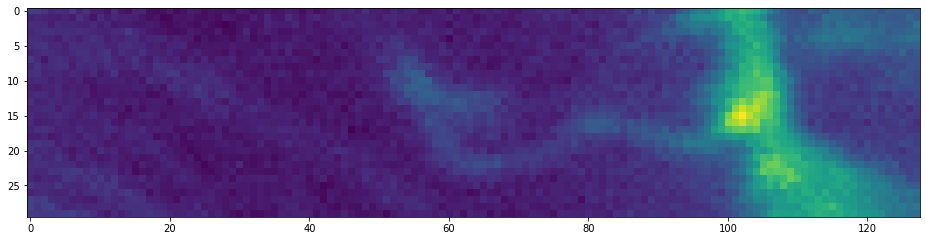

In [22]:
DENDRITE = np.std(stable, axis=0)
plt.imshow(DENDRITE)

In [23]:
# PAINT THE ROI IN THE NAPARI WINDOW
ROI = np.zeros(DENDRITE.shape)
viewer = napari.Viewer()
viewer.add_image(DENDRITE)
viewer.add_labels(ROI)


<Labels layer 'ROI' at 0x7f76d56e3cf8>

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0


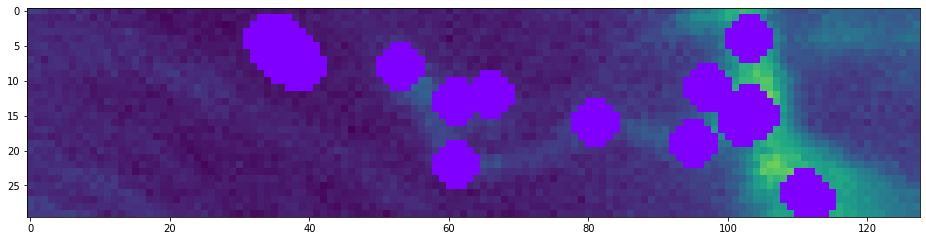

In [24]:
# DISPLAY THE IMAGING AREA AND ROIs
plt.imshow(DENDRITE)
ROI_LABLES = np.unique(ROI)
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = np.nan      
        plt.imshow(mask, cmap='rainbow')

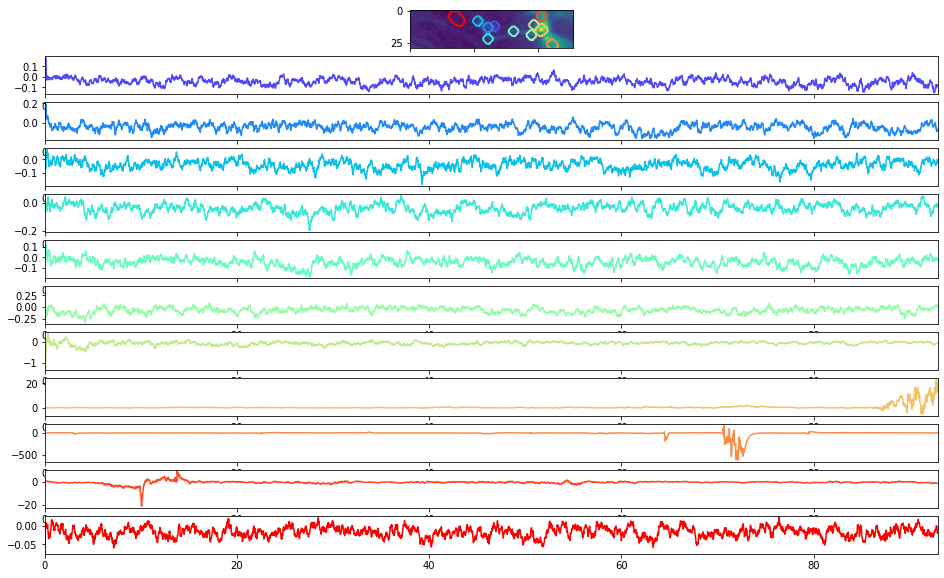

In [28]:
# PLOTS DF/F OF ROI OVER STD PROJECTION OF THE SAMPLE MOVIE


rainbow = cm.get_cmap('rainbow', len(ROI_LABLES))
time = np.arange(stable.shape[0])/HZ

ROI_LABLES = np.unique(ROI)
fig, axs = plt.subplots(len(ROI_LABLES), )
axs[0].imshow(DENDRITE)
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = 0
        mask[mask!=0] = 1
        roi_trace = returnROITrace(stable, mask)
        roi_trace = pnf.deltaFOverF0(roi_trace, 80)
        #roi_trace = pnf.nndSmooth(roi_trace, 22.12, .023 )
        contour = measure.find_contours(mask, .3)
        axs[0].plot(contour[0][:, 1],contour[0][:, 0], linewidth=2, color=rainbow(roi/ROI_LABLES.max()))
        axs[int(roi)].plot(time,roi_trace, color=rainbow(roi/ROI_LABLES.max()))
        axs[int(roi)].set_xlim([0,np.max(time)])
        #axs[int(roi)].set_ylim([-6,45])
        if STIM_FILE is not None:
            for stim in stim2plot:
                axs[int(roi)].axvline(x=(stim/HZ), ls='--', color='grey')            
 
        

In [29]:
stim2plot

[]